# NEOSSat Image Reduction

This worksheet is intended to help get you started with cleaning of NEOSSat Photometry. 
If you have any questions, do not hesitate to contact me. 

I recommend processing one day of NEOSSat data at a time.  Dark-correction is based on creatation of a master-dark from dark images obtained on the same day.  The master-dark is then scaled to match science images.  

I have a paper about to be summited to document the data reduction.  If you find these routines useful, please contact me for the appropriate reference.  

Regards,  
Jason  
(jason.rowe@ubishops.ca) 


Updates:  
2019-09-17 
 - Added Keywords for better FITS compatability  
 - Saved images have 16-bit precision to save disk space.


## Set up...

In [1]:
#Base libraries for interactive work
import numpy as np #We will make extensive use of Numpy arrays 
import multiprocessing as mp #Enable multiprocessing
from tqdm import tqdm_notebook #For monitoring process of big jobs
from astropy.io import fits #astropy modules for FITS IO
import re #to extract trim sections for FITS header

#Based libraries for iPython Plots
import matplotlib  #ploting
matplotlib.use("Agg")  #some hack to stop the bouncing python icon when plotting of os/x
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images
import time as t
%matplotlib inline

#import medfit  #Fortran backend for median fits (this is much faster and reliable than the python version)

import neossatlib as neo  #Main Python Libs for NEOSSat processing.  

def barupdate(result):
    pbar.update()

## Setting Up Necessary Parameters

You can download an example dataset with the following link:
https://kona.ubishops.ca/NEOSSat/K1625example.tgz

Extract the contents into the 'raw' directory from this distribution and we can get started! 

The code expects a simple text file identified by 'fileslist'.  This file is a simple list of the raw FITS files.  It needs to be located in the 'workdir' location. 

You should also pay attention to the 'nprocessor' parameter.  This code will take advantage of multi-core CPUs. Set this number equal to number of processors you will be using our your computing resource. 


### Assumptions:  
 - I assume that all images have the same dimensions.  This will fail if images with different raster sizes are mixed.
 - A master-dark based on image medians can be used to dark-correct all science images, based on linear scaling 
 - electonic noise pattern is coherent and predictable

In [2]:
workdir='raw/'  #Directory that contains FITS files (don't forget the trailing "/")
savedir="clean/" #Directory to save cleaned images. 
#fileslist is located in 'workdir'
fileslist='files_raw_K1625.list' #Simple text file that contains the names of all the FITS files to process.  
bpix=-1.0e10                   #value to mark bad pixels. Any pixel *below* bpix is considered invalid.
sigscalel=1.0                  #low bounds for display clipping.  Keep small to keep background 'dark'
sigscaleh=1.0                  #high bounds for display clipping.
nprocessor=24                  #Number of processors to use for data processing. 
#--- Parameters for making a Dark image ---#
ilow=1                         #number of low value frames to reject when generating dark image
ihigh=1                        #number of high value frames to reject when generating dark image
#--- Parameters for Fourier Decomp. ---#
snrcut=10.0  #When to stop decomposition 
fmax=2 #Maximum number of frequencies in model
xoff=0 #pixel offsets 
yoff=0
T=8 #Oversampling for FFT calculations to better estimate frequency of electronic interference.  
info=0 # 0 - no plots, no output, 1 - no plots, output, 2 - plots, output

imagefiles=neo.read_file_list(workdir+fileslist)

## Get raster dimensions  
- Todo: scan through entire list to check that dimensions are consistent 

In [3]:
#Use the first image to set dimensions for processing.
i=0 #index of first image.  
filename=workdir+imagefiles[i]
trim,btrim,xsc,ysc,xov,yov=neo.getimage_dim(filename)

## Get list of Dark Images

In [4]:
darklist=[]
nfiles=len(imagefiles)
icount=0
for i in range(nfiles):
    filename=workdir+imagefiles[i]
    hdulist = fits.open(filename)
    shutter=hdulist[0].header['SHUTTER']
    if int(shutter[0]) != 0:  #Check if shutter was open or closed.
        darklist.append(imagefiles[i])
    hdulist.close()
    icount=icount+1 #simple counter to track images reviewed.
print("Number of dark images: ",len(darklist))

Number of dark images:  130


## Lets see an image to confirm settings are corrrect for overscan and science subrasters

The overscan is seen to the left.  You will notice an obvious electronic noise pattern. We will model this pattern though Fourier Decomposition. 

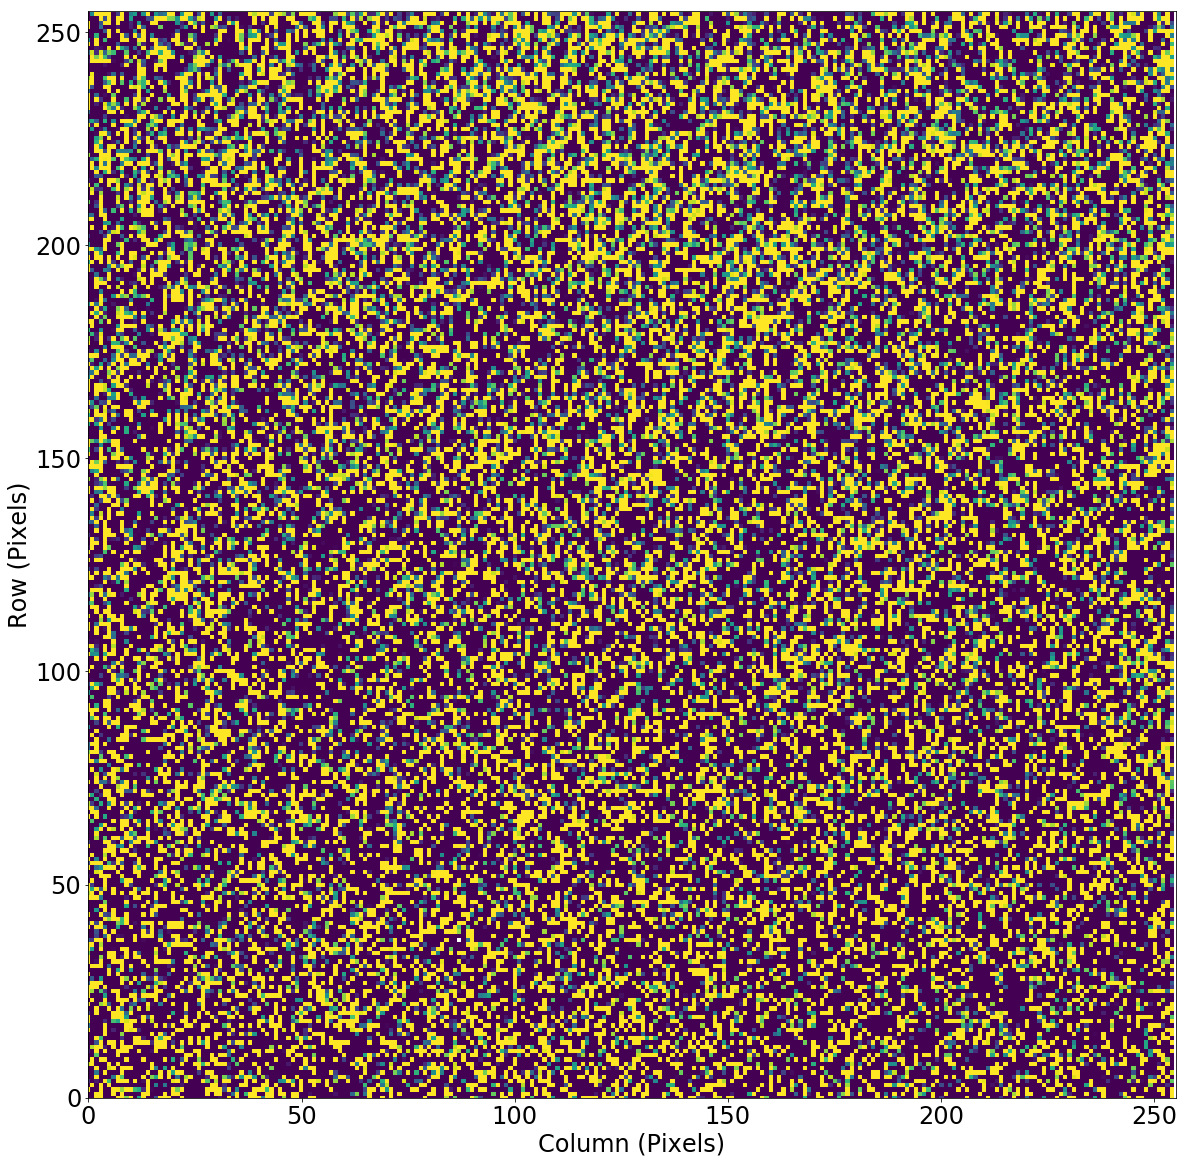

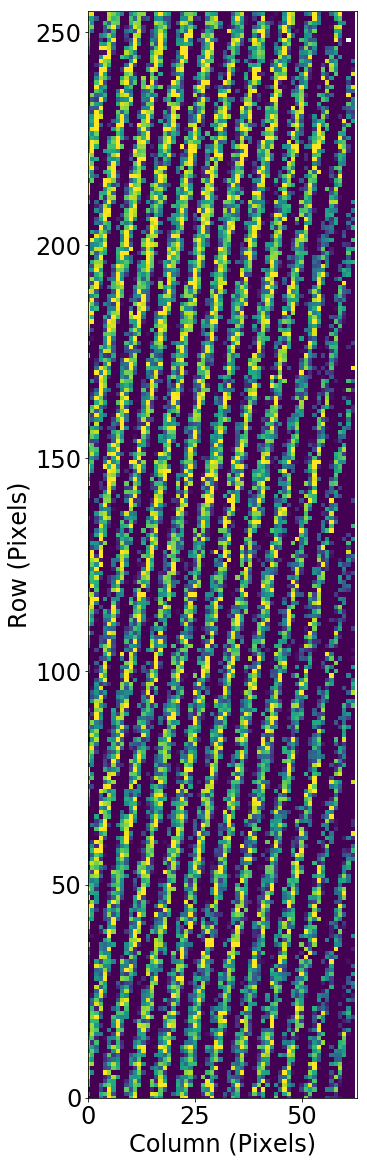

In [5]:
image=neo.read_fitsdata(workdir+darklist[1])

#Plot Science Raster
imstat=neo.imagestat(image[trim[2]:trim[3],trim[0]:trim[1]],bpix)
neo.plot_image(image[trim[2]:trim[3],trim[0]:trim[1]],imstat,0.1,1.5)  #The last two parameters control the plot scale (sigma-low, sigma-high)

#Plot Overscan Raster
imstat=neo.imagestat(image[btrim[2]:btrim[3],btrim[0]:btrim[1]],bpix)
neo.plot_image(image[btrim[2]:btrim[3],btrim[0]:btrim[1]],imstat,0.1,1.5)

## Process the Dark Images.  

Overscan and bias corrections are applied.

Remember, the nprocessor variable sets the number of processors that is used.  Use appropriately.

When running, a taskbar will appear to give you process updates and a rough ETA. On my machine it takes about 10 minutes to process 130 images with 256x256 raster size using 24 cores.  Most of the processing time is consumed with computing Fourier decomposition solutions to deal with electronic noise.  

In [6]:
pbar = tqdm_notebook(total=len(darklist))  #Will make a progressbar to monitor processing.  
pool = mp.Pool(processes=nprocessor)  #Use lots of threads - because we can! 
results = [pool.apply_async(neo.darkprocess, args=(workdir,darkfile,xsc,ysc,xov,yov,snrcut,fmax,xoff,yoff,T,\
                bpix,),callback=barupdate) for darkfile in darklist]
alldarkdata = [p.get() for p in results]
pool.close()
pool.join()

As a note, if you abort any of the multiprocessing commands, then you will need to issue the commands below to clean up any left over running spawns and children.

In [6]:
## Tasks to clean up multiprocessing if it is aborted.  
#pool.close()
#pool.terminate()
#pool.join()

## Combine Darks  

Darks are scaled to match each other, then a median average is applied.  

You may notice that I do an arbitary cut on pixel values to remove obvious stellar objects and background noise.  The choice is a bit arbitary and can probably be improved.

In [11]:
darkavg=neo.combinedarks(alldarkdata)

## Display Master Dark

If you want, this is a good time to save the master dark for future reference.

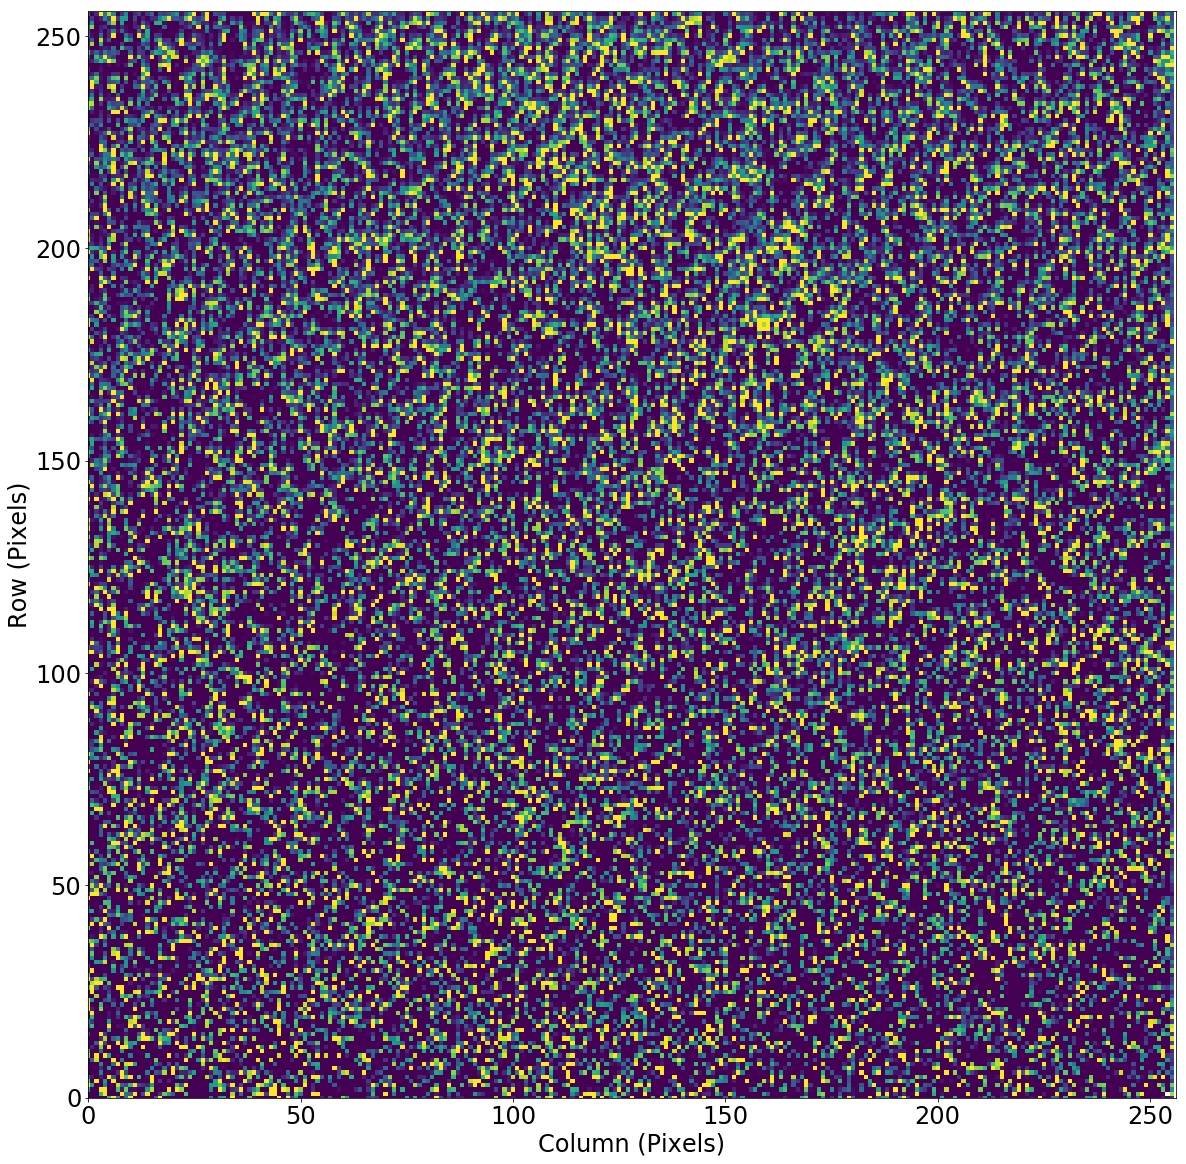

In [12]:
imstat=neo.imagestat(darkavg,bpix)
neo.plot_image(darkavg,imstat,0.3,10.0)

## If we are happy with the Master dark, then clean up workspace

In [9]:
alldarkdata = []

## Get List of Light Images  

A valid science image has SHUTTER=0 (open) and MODE=16 (fine-point).  If you are using a different tracking mode, you will need to update the 'if' statement below. 

In [13]:
lightlist=[]
jddate=[]
exptime=[]
nfiles=len(imagefiles)
for i in range(nfiles):
    filename=workdir+imagefiles[i]
    hdulist = fits.open(filename)
    shutter=hdulist[0].header['SHUTTER']
    mode=hdulist[0].header['MODE']
    # Mode=16 => Fine point.  Mode=13 => Fine Slew
    if (int(shutter[0]) == 0) & ( (int(mode[0:2]) == 16) or (int(mode[0:2]) == 13) ):  #Check if shutter was open or closed.
        lightlist.append(imagefiles[i])
        jddate.append(float(hdulist[0].header['JD-OBS']))
        exptime.append(float(hdulist[0].header['EXPOSURE']))
    hdulist.close()
jddate=np.array(jddate)
exptime=np.array(exptime)
print("number of images: ",len(lightlist))

number of images:  289


## Process a light Image  

Let's process a single image and then plot it.

First, lets look at a raw image:

0.0 65535.0


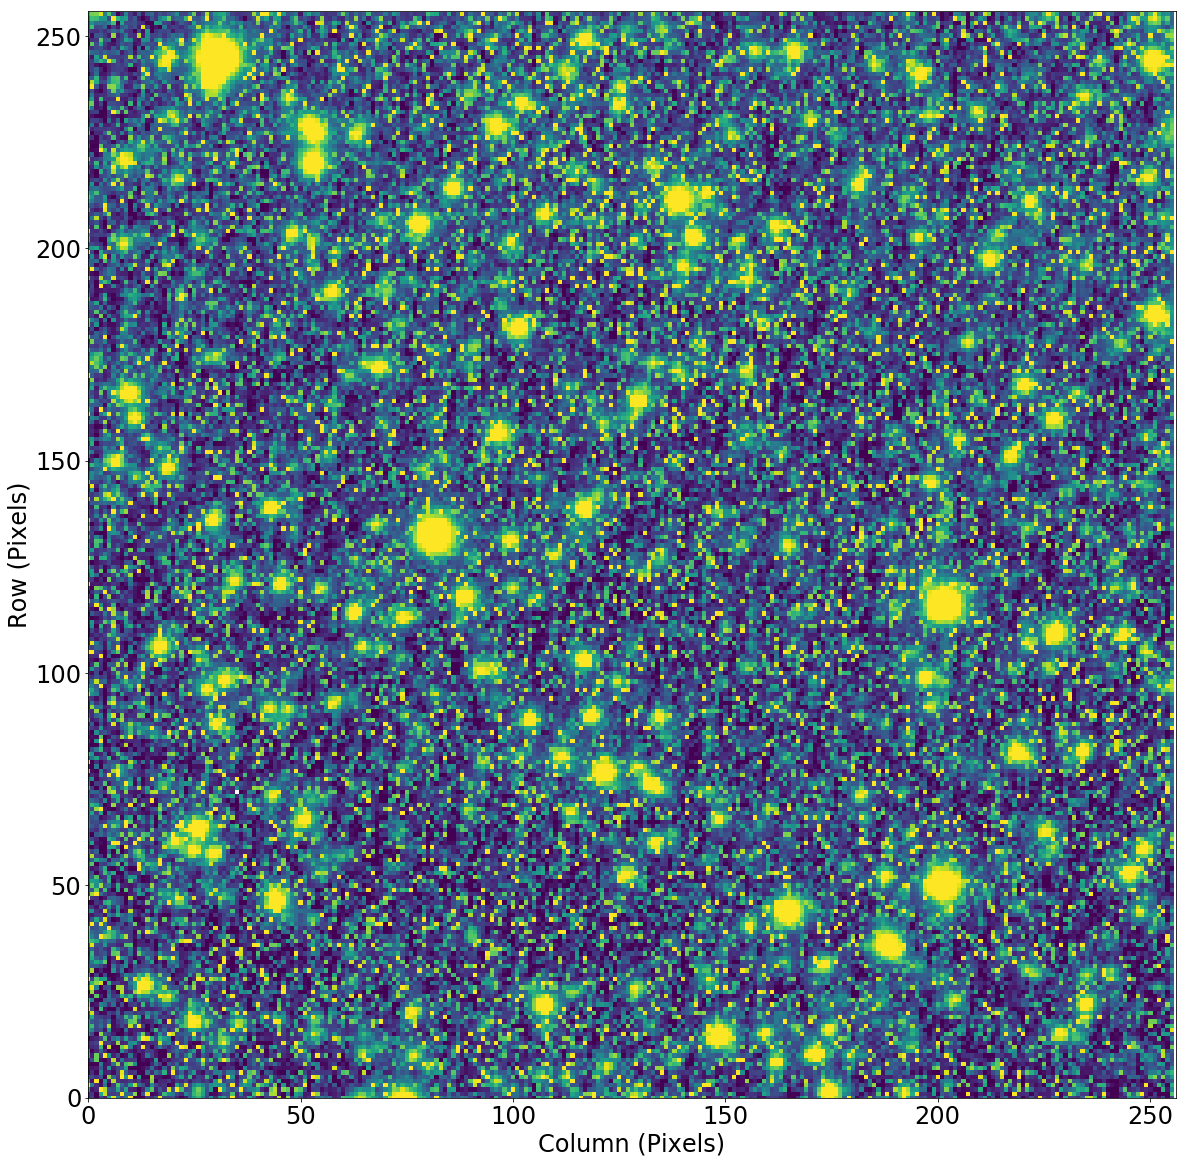

In [14]:
filename=workdir+lightlist[int(len(lightlist)/2)]  #pick an image somewhere around the middle.  
scidata=neo.read_fitsdata(filename)
print(np.min(scidata),np.max(scidata))
#Crop Science Image
sh=scidata.shape
strim=np.array([sh[0]-xsc,sh[0],sh[1]-ysc,sh[1]])
scidata_c=np.copy(scidata[strim[0]:strim[1],strim[2]:strim[3]])
imstat=neo.imagestat(scidata_c,bpix)
neo.plot_image(scidata_c,imstat,1.0,10.0)

and here is the cleaned image to compare to.  There are some very hot-pixels that have non-linear response.  These can be identified from the Master Dark and masked if necessary.

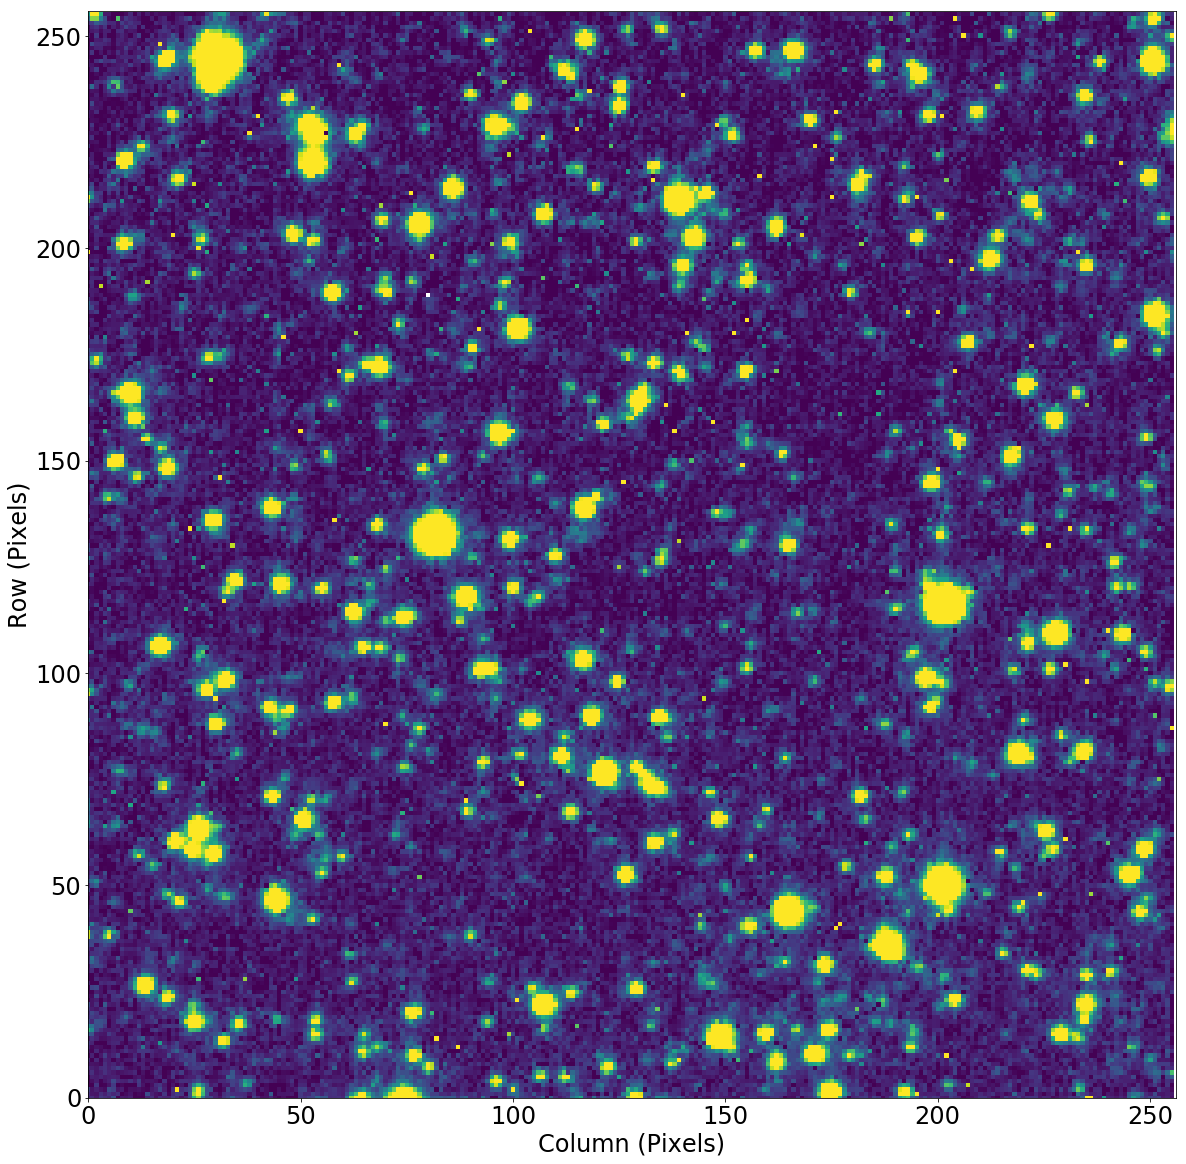

In [15]:
scidata_cord=\
  neo.clean_sciimage(filename,darkavg,xsc,ysc,xov,yov,snrcut,fmax,xoff,yoff,T,info,bpix)

imstat=neo.imagestat(scidata_cord,bpix)
neo.plot_image(scidata_cord,imstat,1.0,10.0)

## Batch process and save cleaned images

If you are happy with the processing, then we can batch process everything.  The processed images will be saved in the 'clean' directory as specified above.

In [ ]:
pbar = tqdm_notebook(total=len(lightlist))  #Progress bar.
pool = mp.Pool(processes=24)  #How many threads to use.
results = [pool.apply_async(neo.lightprocess_save, args=(workdir+lightlist[i],savedir,darkavg,xsc,ysc,xov,yov,\
           snrcut,fmax,xoff,yoff,T,bpix,),callback=barupdate)\
           for i in range(len(lightlist))]
saveall = [p.get() for p in results]
pool.close()
pool.join()

In [64]:
## Tasks to clean up multiprocessing if it is aborted.  
#pool.close()
#pool.terminate()
#pool.join()